In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.3


In [2]:
K.set_image_data_format('channels_first')


In [3]:
N_Cls = 10
inDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [4]:

def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img

def P(image_id):
    filename = os.path.join(inDir, 'sixteen_band', '{}_P.tif'.format(image_id))
    img = tiff.imread(filename)    
    return img

def RGB(image_id):
    filename = os.path.join(inDir, 'three_band', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)    
    return img
    

def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)


def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


In [5]:
stick_all_train()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


In [6]:
def make_val():
    print "let's pick some samples for validation"
    img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save(inDir + '/data/x_tmp_%d' % N_Cls, x)
    np.save(inDir + '/data/y_tmp_%d' % N_Cls, y)

In [7]:
make_val()

let's pick some samples for validation
(1039, 8, 160, 160) (1039, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [8]:

def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


def calc_jacc(model):
    img = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls), np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)
    img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights(inDir + '/weights/unet_10_jk0.7076')
    model_checkpoint = ModelCheckpoint(inDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, epochs=2, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(inDir + '/weights/unet_10_jk%.4f' % score)

    return model


def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(inDir + '/msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id


def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load(inDir + '/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(inDir + '/subm/1.csv', index=False)


def check_predict(id='6120_2_3'):
    model = get_unet()
#     model.load_weights(inDir + '/weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()



In [34]:
inputs = Input((8, ISZ, ISZ))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 8, 160, 160)       0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 32, 160, 160)      2336      
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 160, 160)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 80, 80)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 64, 80, 80)        18496     
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 64, 80, 80)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 40, 40)        0         
__________

In [28]:
x_val, y_val = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls), np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

In [29]:
x_trn, y_trn = get_patches(img, msk)

(3439, 8, 160, 160) (3439, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [33]:
x_val.shape, y_val.shape

((1011, 8, 160, 160), (1011, 10, 160, 160))

In [36]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True, validation_data=(x_val, y_val))

Train on 3439 samples, validate on 1011 samples
Epoch 1/1
3439/3439 [==============================] - 386s - loss: 0.2926 - jaccard_coef: 0.0463 - jaccard_coef_int: 0.0174 - acc: 0.8883 - val_loss: 0.1887 - val_jaccard_coef: 0.0448 - val_jaccard_coef_int: 3.3715e-04 - val_acc: 0.9236


In [9]:
model = train_net()

start train net
(3530, 8, 160, 160) (3530, 10, 160, 160) 1.0 -1.0 1.0 0.0
Train on 3530 samples, validate on 1039 samples
Epoch 1/2
3530/3530 [==============================] - 391s - loss: 0.3243 - jaccard_coef: 0.0471 - jaccard_coef_int: 0.0176 - acc: 0.8724 - val_loss: 0.1922 - val_jaccard_coef: 0.0501 - val_jaccard_coef_int: 0.0417 - val_acc: 0.9175
Epoch 2/2
3530/3530 [==============================] - 378s - loss: 0.1877 - jaccard_coef: 0.0495 - jaccard_coef_int: 0.0109 - acc: 0.9235 - val_loss: 0.1831 - val_jaccard_coef: 0.0544 - val_jaccard_coef_int: 0.0065 - val_acc: 0.9230
(3564, 8, 160, 160) (3564, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1039, 10, 160, 160) (1039, 10, 160, 160)
0 0.734618623677 0.7
1 0.646691530318 0.4
2 0.816782964389 0.5
3 0.397479547642 0.5
4 0.168395809543 0.1
5 0.466788979788 0.8
6 0.947135206381 0.7
7 0.961266843118 0.4
8 0.988949711261 0.4
9 0.948147256978 0.3
val jk 0.707625647309


In [ ]:
model = train_net()

start train net
(3551, 8, 160, 160) (3551, 10, 160, 160) 1.0 -1.0 1.0 0.0
Train on 3551 samples, validate on 1039 samples
Epoch 1/2
3551/3551 [==============================] - 386s - loss: 0.2494 - jaccard_coef: 0.0460 - jaccard_coef_int: 0.0139 - acc: 0.8956 - val_loss: 0.1871 - val_jaccard_coef: 0.0468 - val_jaccard_coef_int: 0.0012 - val_acc: 0.9228
Epoch 2/2
3551/3551 [==============================] - 380s - loss: 0.1824 - jaccard_coef: 0.0533 - jaccard_coef_int: 0.0203 - acc: 0.9230 - val_loss: 0.1802 - val_jaccard_coef: 0.0565 - val_jaccard_coef_int: 0.0118 - val_acc: 0.9236
(3551, 8, 160, 160) (3551, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1039, 10, 160, 160) (1039, 10, 160, 160)
0 0.734618623677 0.9
1 0.646691530318 0.4
2 0.816782964389 0.5
3 0.397479547642 0.5


In [38]:
# model = train_net()
score, trs = calc_jacc(model)

(1011, 10, 160, 160) (1011, 10, 160, 160)
0 0.740399357072 0.5
1 0.660163204748 0.6
2 0.843725272008 0.5
3 0.401514589515 0.5
4 0.166494636143 0.1
5 0.476774233432 0.6
6 0.932325667656 0.5
7 0.963482937685 0.4
8 0.988754945598 0.4
9 0.947712660732 0.5


In [39]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


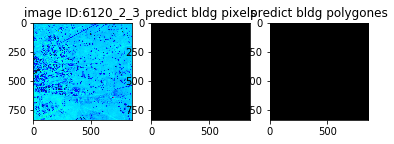

In [42]:
check_predict()